In [ ]:
! pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import lru_cache
from Levenshtein import distance as levenshtein_distance
from collections import defaultdict
import numpy as np


# Прочтение таблиц

In [ ]:
data = pd.read_csv("/content/Mengsk.tsv")
data.head()

,count\tfreq\tcdr3nt\tcdr3aa\tv\td\tj\tVEnd\tDStart\tDEnd\tJStart
0,32191\t0.03576809571640637\tTGTGCCAGCAGCTTAGTC...
1,21204\t0.02356020942408377\tTGTGCCAGCAGCGACCCC...
2,8530\t0.009477862025440226\tTGTGCCATCGGGACAGGC...
3,7293\t0.008103405363603232\tTGTGCCAGCCTTGGAGGC...
4,4969\t0.005521160188090561\tTGTGCCAGCAGTTTAGGT...


In [ ]:
df = pd.DataFrame(data)
df.columns = ['data']
df['CDR3.amino.acid.sequence'] = df['data'].str.split('\t').str[3]
df['Read.proportion'] = df['data'].str.split('\t').str[1]
df['Read.proportion'] = pd.to_numeric(df['Read.proportion'])
df['Read.count'] = df['data'].str.split('\t').str[0]
df['bestVGene'] = df['data'].str.split('\t').str[4]
df['bestJGene'] = df['data'].str.split('\t').str[6]
del df['data']
df

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene
0,CASSLVSGANVLTF,0.035768,32191,TRBV7-9,TRBJ2-6
1,CASSDPQSSYNSPLHF,0.023560,21204,TRBV7-8,TRBJ1-6
2,CAIGTGDSNQPQHF,0.009478,8530,TRBV10-3,TRBJ1-5
3,CASLGGRSSYNSPLHF,0.008103,7293,TRBV6-5,TRBJ1-6
4,CASSLGVGTYEQYF,0.005521,4969,TRBV27,TRBJ2-7
...,...,...,...,...,...
63732,CASRGARTFF,0.000002,2,TRBV25-1,TRBJ1-1
63733,CASSDYEQYF,0.000002,2,TRBV25-1,TRBJ2-7
63734,CASYGDTQYF,0.000002,2,TRBV25-1,TRBJ2-3
63735,CASSVEPQHF,0.000002,2,TRBV19,TRBJ1-5


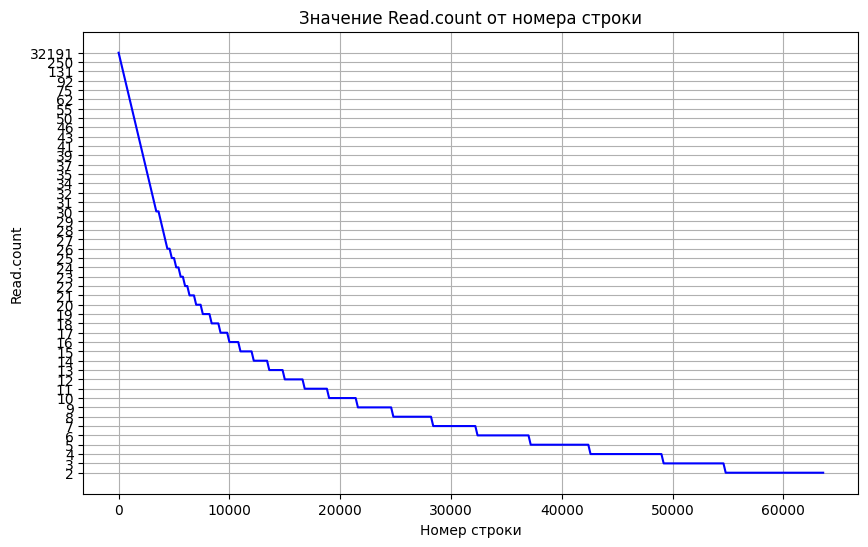

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[::200], df['Read.count'][::200], linestyle='-', color='b')
plt.xlabel('Номер строки')
plt.ylabel('Read.count')
plt.title('Значение Read.count от номера строки')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
index_30 = df[df['Read.count'] == '40'].index
print(index_30)

Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059,
       2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071,
       2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083,
       2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095,
       2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107],
      dtype='int64')


In [ ]:
database = pd.read_excel("/content/vdjdb_slim.xlsx")

In [ ]:
database_exp = database.rename(columns={'cdr3': 'CDR3.amino.acid.sequence'})

In [ ]:
data_claster = df[:2012]
data_claster

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene
0,CASSLVSGANVLTF,0.035768,32191,TRBV7-9,TRBJ2-6
1,CASSDPQSSYNSPLHF,0.023560,21204,TRBV7-8,TRBJ1-6
2,CAIGTGDSNQPQHF,0.009478,8530,TRBV10-3,TRBJ1-5
3,CASLGGRSSYNSPLHF,0.008103,7293,TRBV6-5,TRBJ1-6
4,CASSLGVGTYEQYF,0.005521,4969,TRBV27,TRBJ2-7
...,...,...,...,...,...
2007,CASSPPWGTEAFF,0.000046,41,TRBV14,TRBJ1-1
2008,CASSEASGANVLTF,0.000046,41,TRBV2,TRBJ2-6
2009,CASRPTAGPNTEAFF,0.000046,41,TRBV2,TRBJ1-1
2010,CASSFSPYEQYF,0.000046,41,TRBV6-6,TRBJ2-7


# Функция кластеризации

In [ ]:
# Кэшированная функция для вычисления расстояния Левенштейна
@lru_cache(maxsize=None)
def cached_levenshtein_distance(seq1, seq2):
    return levenshtein_distance(seq1, seq2)

# Функция для кластеризации последовательностей
def cluster_sequences(sequences, max_distance=1):
    clusters = []
    for seq in sequences:
        added_to_cluster = False
        for cluster in clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for existing_seq in cluster):
                cluster.append(seq)
                added_to_cluster = True
                break
        if not added_to_cluster:
            clusters.append([seq])
    return clusters

# Функция для объединения кластеров
def merge_clusters(clusters, max_distance=1):
    merged_clusters = []
    for cluster in clusters:
        added_to_cluster = False
        for merged_cluster in merged_clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for seq in cluster for existing_seq in merged_cluster):
                merged_cluster.extend(cluster)
                added_to_cluster = True
                break
        if not added_to_cluster:
            merged_clusters.append(cluster)
    return merged_clusters

# Пример последовательностей аминокислот
sequences = data_claster['CDR3.amino.acid.sequence']

# Разделение данных на части
chunk_size = len(sequences) // 100
chunks = [sequences[i:i + chunk_size] for i in range(0, len(sequences), chunk_size)]

# Кластеризация каждой части
all_clusters = []
for chunk in chunks:
    all_clusters.extend(cluster_sequences(chunk, max_distance=1))

# Объединение кластеров
final_clusters = merge_clusters(all_clusters, max_distance=1)

# Вывод результатов
# Создание DataFrame
cluster_data = []
for i, cluster in enumerate(final_clusters):
    for seq in cluster:
        cluster_data.append({'Cluster': i + 1, 'Sequence': seq})

results_df = pd.DataFrame(cluster_data)

In [ ]:
# Создание нового DataFrame с данными из data_claster и номером кластера
cluster_assignments = {}
for i, cluster in enumerate(final_clusters):
  for seq in cluster:
    cluster_assignments[seq] = i + 1

results_df = data_claster.copy()
results_df['Cluster'] = results_df['CDR3.amino.acid.sequence'].map(cluster_assignments)

# Вывод нового DataFrame results_df
results_df


,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene,Cluster
0,CASSLVSGANVLTF,0.035768,32191,TRBV7-9,TRBJ2-6,1
1,CASSDPQSSYNSPLHF,0.023560,21204,TRBV7-8,TRBJ1-6,2
2,CAIGTGDSNQPQHF,0.009478,8530,TRBV10-3,TRBJ1-5,3
3,CASLGGRSSYNSPLHF,0.008103,7293,TRBV6-5,TRBJ1-6,4
4,CASSLGVGTYEQYF,0.005521,4969,TRBV27,TRBJ2-7,5
...,...,...,...,...,...,...
2007,CASSPPWGTEAFF,0.000046,41,TRBV14,TRBJ1-1,1849
2008,CASSEASGANVLTF,0.000046,41,TRBV2,TRBJ2-6,368
2009,CASRPTAGPNTEAFF,0.000046,41,TRBV2,TRBJ1-1,1850
2010,CASSFSPYEQYF,0.000046,41,TRBV6-6,TRBJ2-7,1851


# Подсчёт Total Read Proportion

In [ ]:
# Подсчет суммарного Read.proportion для каждого кластера
cluster_proportions = {}
cluster_counts = {}
for index, row in data_claster.iterrows():
  seq = row['CDR3.amino.acid.sequence']
  proportion = row['Read.proportion']
  for i, cluster in enumerate(final_clusters):
    if seq in cluster:
      cluster_proportions[i + 1] = cluster_proportions.get(i + 1, 0) + proportion
      cluster_counts[i + 1] = cluster_counts.get(i + 1, 0) + 1
      break

# Создание DataFrame с суммарными пропорциями, номерами кластеров и количеством последовательностей
proportions_data = []
for cluster_number, total_proportion in cluster_proportions.items():
  proportions_data.append({'Cluster': cluster_number,
               'Total Read Proportion': total_proportion,
               'Sequence Count': cluster_counts[cluster_number]})



# Сортировка по Sequence Count

In [ ]:
proportions_df = pd.DataFrame(proportions_data)
proportions_df = proportions_df.sort_values(by='Sequence Count', ascending=False)
proportions_df

,Cluster,Total Read Proportion,Sequence Count
2,3,0.028498,27
470,471,0.000473,6
34,35,0.001792,5
12,13,0.003363,4
94,95,0.000809,4
...,...,...,...
659,660,0.000090,1
658,659,0.000090,1
657,658,0.000090,1
656,657,0.000090,1


# Сортировка по Total Read Proportion

In [ ]:
proportions_df_sorted = proportions_df.sort_values(by='Total Read Proportion', ascending=False)
proportions_df_sorted = proportions_df_sorted.loc[proportions_df_sorted['Sequence Count'] > 1]
proportions_df_sorted

,Cluster,Total Read Proportion,Sequence Count
2,3,0.028498,27
12,13,0.003363,4
18,19,0.002498,2
25,26,0.002299,4
22,23,0.002041,2
...,...,...,...
984,985,0.000113,2
1060,1061,0.000112,2
1375,1376,0.000106,2
1436,1437,0.000104,2


# Выбор кластера

In [ ]:
full = pd.merge(results_df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,3,CAIGTGDSNQPQHF,0.009478,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
1,3,CAIGTGDSNQPQHF,0.002710,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
2,3,CATGTGDSNQPQHF,0.002096,TRBV10-3,TRBJ1-5,TRBV19*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,EBNA4
3,3,CATGTGDSNQPQHF,0.002096,TRBV10-3,TRBJ1-5,TRBV19*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
4,3,CATGTGDSNQPQHF,0.002096,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
...,...,...,...,...,...,...,...,...,...,...,...
121,1545,CASSLGRGEQYF,0.000050,TRBV13,TRBJ2-7,TRBV7-2*01,TRBJ2-7*01,MHCII,HomoSapiens,InfluenzaA,HA
122,1061,CASSTNTEAFF,0.000049,TRBV6-6,TRBJ1-1,TRBV27*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
123,62,CASSLQGNQPQHF,0.000048,TRBV7-2,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,InfluenzaA,M
124,1650,CASSHRTSGRNEQFF,0.000048,TRBV4-1,TRBJ2-1,TRBV4-2*01,TRBJ2-1*01,MHCI,HomoSapiens,HCV,NS3


In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])]
full_vj

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,3,CAIGTGDSNQPQHF,0.009478,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
1,3,CAIGTGDSNQPQHF,0.002710,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
4,3,CATGTGDSNQPQHF,0.002096,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
5,3,CAISTGDSNQPQHF,0.002006,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
6,3,CAISTGDSNQPQHF,0.002006,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,HomoSapiens,MLANA
7,3,CAISTGDSNQPQHF,0.002006,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
33,3,CAIGTGDSNQPQHF,0.001209,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
34,3,CAIGTGDSNQPQHF,0.001149,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
39,3,CAIGTGDTNQPQHF,0.000592,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,EBNA4
40,3,CAIGTGDTNQPQHF,0.000592,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1


In [ ]:
full_vj['Cluster'].value_counts()

,count
Cluster,
3,16
816,2
785,2
411,1
722,1
733,1
734,1
703,1
559,1


# Обработка для одного выбранного кластера

In [ ]:
results_df_one_cluster = results_df.loc[results_df['Cluster'] == 3]
results_df_one_cluster = results_df_one_cluster.rename(columns={'Sequence': 'CDR3.amino.acid.sequence'})
results_df_one_cluster

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene,Cluster
2,CAIGTGDSNQPQHF,0.009478,8530,TRBV10-3,TRBJ1-5,3
16,CAIGTGDSNQPQHF,0.002710,2439,TRBV10-3,TRBJ1-5,3
22,CATGTGDSNQPQHF,0.002096,1886,TRBV10-3,TRBJ1-5,3
24,CAISTGDSNQPQHF,0.002006,1805,TRBV10-3,TRBJ1-5,3
26,CATSTGDSNQPQHF,0.001957,1761,TRBV10-3,TRBJ1-5,3
37,CATSTGDSNQPQHF,0.001553,1398,TRBV10-3,TRBJ1-5,3
43,CASSTGDSNQPQHF,0.001238,1114,TRBV19,TRBJ1-5,3
44,CAIGTGDSNQPQHF,0.001209,1088,TRBV10-3,TRBJ1-5,3
46,CAIGTGDSNQPQHF,0.001149,1034,TRBV10-3,TRBJ1-5,3
59,CASGTGDSNQPQHF,0.000883,795,TRBV19,TRBJ1-5,3


In [ ]:
full = pd.merge(results_df_one_cluster, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,3,CAIGTGDSNQPQHF,0.009478,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
1,3,CAIGTGDSNQPQHF,0.002710,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
2,3,CATGTGDSNQPQHF,0.002096,TRBV10-3,TRBJ1-5,TRBV19*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,EBNA4
3,3,CATGTGDSNQPQHF,0.002096,TRBV10-3,TRBJ1-5,TRBV19*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
4,3,CATGTGDSNQPQHF,0.002096,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
5,3,CAISTGDSNQPQHF,0.002006,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
6,3,CAISTGDSNQPQHF,0.002006,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,HomoSapiens,MLANA
7,3,CAISTGDSNQPQHF,0.002006,TRBV10-3,TRBJ1-5,TRBV10-3*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
8,3,CATSTGDSNQPQHF,0.001957,TRBV10-3,TRBJ1-5,TRBV15*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BZLF1
9,3,CATSTGDSNQPQHF,0.001957,TRBV10-3,TRBJ1-5,TRBV15*01,TRBJ1-5*01,MHCI,HomoSapiens,EBV,BMLF1


In [ ]:
full['antigen.gene'].value_counts()

,count
antigen.gene,
BZLF1,24
MLANA,11
IE1,8
EBNA4,6
BMLF1,2
EBNA3A,2
M,2
Gag,2
Spike,1
